<a href="https://colab.research.google.com/github/KarAnalytics/code_demos/blob/main/Attention_in_Image_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import matplotlib.pyplot as plt
import requests
import numpy as np



Predicted Class: beagle


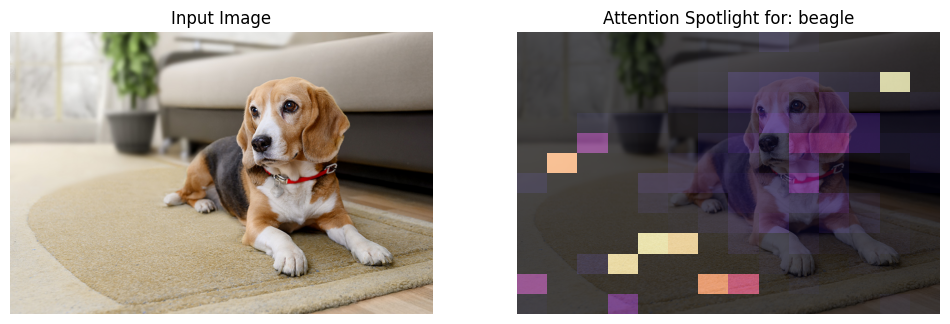

In [10]:
# 1. Load the Model and Processor
model_name = 'google/vit-base-patch16-224'
processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name, output_attentions=True)

# 2. Load an Image (Using a clear cat image)
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg' # Two cats on a remote
#url = 'https://pawpals.ae/wp-content/uploads/2023/03/Shorthair-cat-1-1024x679.jpg'
#url = 'https://www.alleycat.org/wp-content/uploads/2018/08/SocialMediaLink_1200x628_GenericCat-Centered.png'
url = 'https://d3544la1u8djza.cloudfront.net/APHI/Blog/2023/September/small-breeds-hero.jpg'
image = Image.open(requests.get(url, stream=True).raw)

# 3. Process and Predict
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# Find the label with the highest score
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()
print(f"Predicted Class: {model.config.id2label[predicted_class_idx]}")

# 4. Extract Attention for that specific prediction
# We take the last layer's attention (Layer 11)
attentions = outputs.attentions[-1]

# Average the attention weights across all 'heads'
# We focus on the [CLS] token (index 0) which is the 'Decision Maker'
# The [CLS] token's attention toward the 196 image patches (index 1 to 197)
nh = attentions.shape[1] # Number of heads
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
val_attn = attentions.mean(dim=0) # Average across heads

# 5. Reshape and Resize Heatmap
grid_size = int(np.sqrt(val_attn.shape[0])) # 14x14
heatmap = val_attn.reshape(grid_size, grid_size).detach().numpy()

# 6. Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image)
ax[0].set_title("Input Image")
ax[0].axis('off')

# Overlay the heatmap
ax[1].imshow(image)
ax[1].imshow(heatmap, cmap='magma', alpha=0.7, extent=(0, image.size[0], image.size[1], 0))
ax[1].set_title(f"Attention Spotlight for: {model.config.id2label[predicted_class_idx]}")
ax[1].axis('off')

plt.show()